In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import pandas as pd
import numpy as np

In [2]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [2]:
path_img = 'ISIC2018_Task1-2_Training_Input/'
path_ground_truth = 'ISIC2018_Task1_Training_GroundTruth/'

## Preparing the data

In [3]:
get_y_fn = lambda x: path_ground_truth + str(x.stem) + '_segmentation.png'

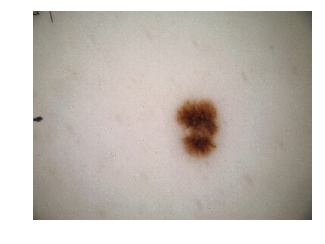

In [16]:
fnames = get_image_files(path_img)
img_f = fnames[3]
img = open_image(img_f)
img.show(figsize=(5,5))

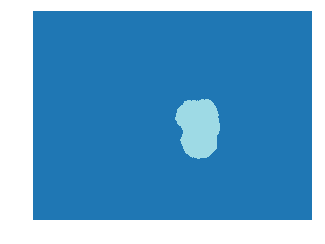

In [17]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [4]:
#make sure all the masks have pixels in range [0, number_of_classes -1]
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [6]:
data = (SegItemListCustom.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_func(get_y_fn, classes = ['skin', 'lesion'])
       .transform(get_transforms(flip_vert=True, max_zoom=1), tfm_y=True, size=240)
       .databunch(bs=4)
       .normalize(imagenet_stats))

In [7]:
data.show_batch(4, figsize = (10,7))

BrokenPipeError: [Errno 32] Broken pipe

## Defining the learner

In [7]:
#this is the ISIC-task1 goal metric
def jacc(input, targs):
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    
    count_inter = sum(input == targs)
    count_all = count_inter + sum(targs != input)
    J = count_inter/(2*count_all - count_inter)
    if J < 0.65: return 0
    else: return J 

In [23]:
def seg_acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [7]:
def dice_seg(input:Tensor, targs:Tensor, iou:bool=True, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return (intersect / (union-intersect+eps) if union > 0 else union.new([1.]).squeeze())

In [8]:
a = models.resnet34

In [10]:
learn = load_learner('C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\CIS\\Projeto Mundim')

C:\Users\thiag\Anaconda3\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [11]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\thiag\Desktop\Thiago\UnB\CIS\Projeto Mundim;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\thiag\Desktop\Thiago\UnB\CIS\Projeto Mundim;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, 

In [8]:
learn = unet_learner(data, models.resnet34, metrics = dice_seg, callback_fns=ShowGraph, wd = 1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


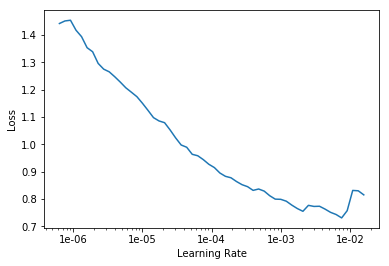

In [10]:
learn.lr_find()
learn.recorder.plot()

In [13]:
def addEarlyStopCallBack(learn):
    learn.callback_fns.append(partial(callbacks.EarlyStoppingCallback, monitor='dice_seg',
                                          min_delta=0.001, patience=5))

In [14]:
addEarlyStopCallBack(learn)

epoch,train_loss,valid_loss,dice_seg,time
0,0.304012,0.264682,0.611594,04:58
1,0.208745,0.190892,0.727949,04:42
2,0.198620,0.179460,0.744451,04:48
3,0.187971,0.244254,0.687476,04:47
4,0.200112,0.230468,0.706677,04:44
5,0.186453,0.165597,0.773353,04:49
6,0.200238,0.169105,0.779390,04:45
7,0.178891,0.168478,0.774222,04:44
8,0.189947,0.174812,0.757180,04:45
9,0.181896,0.164750,0.795348,04:43


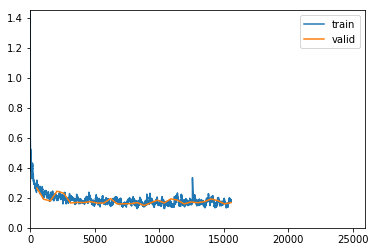

Better model found at epoch 0 with dice_seg value: 0.6115943193435669.
Better model found at epoch 1 with dice_seg value: 0.7279489636421204.
Better model found at epoch 2 with dice_seg value: 0.7444510459899902.
Better model found at epoch 5 with dice_seg value: 0.7733526825904846.
Better model found at epoch 6 with dice_seg value: 0.7793903946876526.
Better model found at epoch 9 with dice_seg value: 0.7953477501869202.
Better model found at epoch 12 with dice_seg value: 0.7985177040100098.
Better model found at epoch 17 with dice_seg value: 0.8018597960472107.
Better model found at epoch 21 with dice_seg value: 0.8023887872695923.
Better model found at epoch 23 with dice_seg value: 0.8041248321533203.
Epoch 29: early stopping


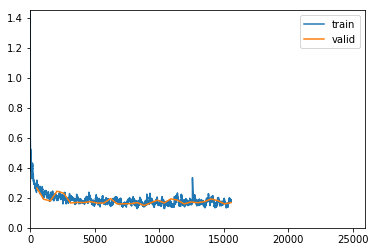

In [13]:
learn.fit_one_cycle(50, slice(1e-3), pct_start=0.9, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='dice_seg', name='best')])

In [14]:
learn.save('stage-1')

In [9]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (2076 items)
x: SegItemListCustom
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegLabelListCustom
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: ISIC2018_Task1-2_Training_Input;

Valid: LabelList (518 items)
x: SegItemListCustom
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegLabelListCustom
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: ISIC2018_Task1-2_Training_Input;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

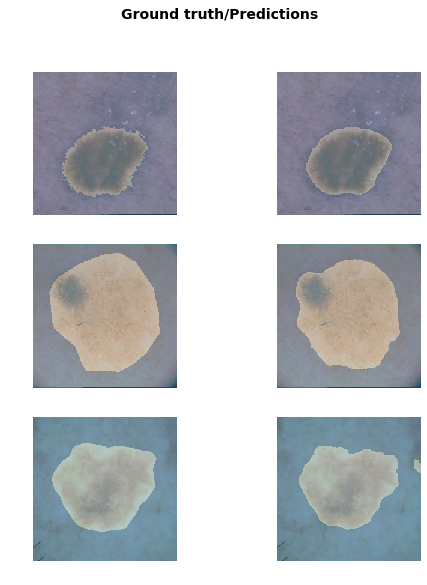

In [10]:
learn.show_results(rows=3, figsize=(8,9))

In [11]:
learn.unfreeze()

In [12]:
lr = 1e-3
lrs = slice(lr/400, lr/4)

epoch,train_loss,valid_loss,dice_seg,time
0,0.130895,0.161656,0.813740,06:15
1,0.135053,0.159440,0.819592,05:56
2,0.129967,0.152019,0.817095,05:53
3,0.135331,0.148122,0.824311,05:55
4,0.138692,0.150171,0.821391,05:53
5,0.113559,0.154478,0.821483,06:00
6,0.119136,0.151449,0.823098,06:06
7,0.136519,0.142618,0.827026,05:55
8,0.122264,0.150867,0.826657,06:03
9,0.116531,0.149494,0.824249,06:06


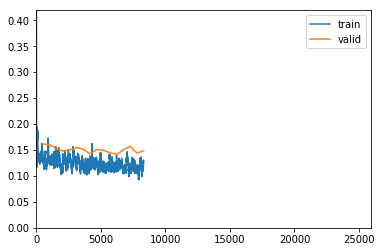

Better model found at epoch 0 with dice_seg value: 0.8137397766113281.
Better model found at epoch 1 with dice_seg value: 0.8195924162864685.
Better model found at epoch 3 with dice_seg value: 0.8243107199668884.
Better model found at epoch 7 with dice_seg value: 0.8270255923271179.
Better model found at epoch 10 with dice_seg value: 0.8303443789482117.


In [ ]:
learn.fit_one_cycle(50, lrs, pct_start=0.8, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='dice_seg', name='best')])

In [9]:
learn.load('best')

Learner(data=ImageDataBunch;

Train: LabelList (2076 items)
x: SegItemListCustom
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegLabelListCustom
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: ISIC2018_Task1-2_Training_Input;

Valid: LabelList (518 items)
x: SegItemListCustom
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegLabelListCustom
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: ISIC2018_Task1-2_Training_Input;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

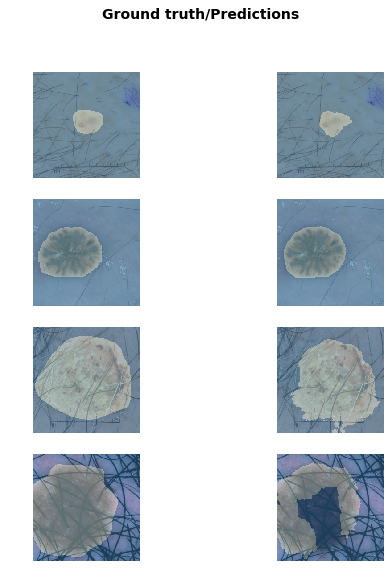

In [11]:
learn.show_results(rows=4,figsize = (8,9))

In [12]:
learn.save('stage-2')

In [14]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (2076 items)
x: SegItemListCustom
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegLabelListCustom
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: ISIC2018_Task1-2_Training_Input;

Valid: LabelList (518 items)
x: SegItemListCustom
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegLabelListCustom
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: ISIC2018_Task1-2_Training_Input;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [15]:
learn.export()